# v4.1

Deng Zhaoguo  
Invalid Date

# Read the data. Pay attention to the correspondence between mutant and wildtype samples, which are located in column 3 (mutant) and column 4 (wt) in this case, respectively.

In [1]:
# Read allele depth file
var_file = "GTRC-Combine.results_var_AD.table"

raw = read.delim(var_file, header = TRUE, colClasses = c("character", "numeric", "character","character"))

# remove positions with no reads in either pool
raw <- raw[!is.na(raw[[3]]) & !is.na(raw[[4]]), ]

# strsplit A,B \t X,Y to A B X Y
wt_col=4
mut_col=3

wt_AD = matrix(as.numeric(unlist(strsplit(raw[, wt_col], ","))), ncol = 2, byrow = TRUE)
mut_AD = matrix(as.numeric(unlist(strsplit(raw[, mut_col], ","))), ncol = 2, byrow = TRUE)

colnames(mut_AD) = colnames(wt_AD) = c("ref_reads", "alt_reads")
TEMP = cbind(raw[, 1:2], mut_AD)
merged_data = cbind(TEMP, wt_AD)

colnames(merged_data) = c("CHROM", "POS", "ref_reads_mut", "alt_reads_mut","ref_reads_wt", "alt_reads_wt")

Example:

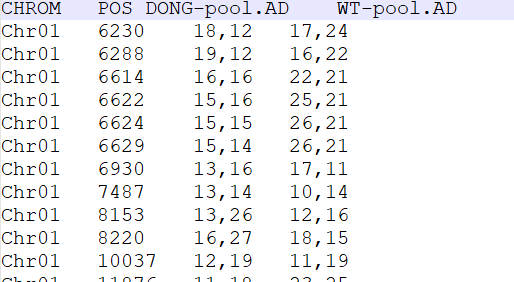

# Calculate allele frequencies

In [2]:
# Calculate allele frequency in mut and wt pools
mut_freq = merged_data$alt_reads_mut / (merged_data$ref_reads_mut + merged_data$alt_reads_mut)
wt_freq = merged_data$alt_reads_wt / (merged_data$ref_reads_wt + merged_data$alt_reads_wt)

# mutate 0
mut_freq[mut_freq == 0] <- 1e-6
wt_freq[wt_freq == 0] <- 1e-6

# Calculate LOD
LOD = log10(
    dbinom(merged_data$alt_reads_mut, size = merged_data$alt_reads_mut + merged_data$ref_reads_mut, prob = mut_freq) *
    dbinom(merged_data$alt_reads_wt, size = merged_data$alt_reads_wt + merged_data$ref_reads_wt, prob = wt_freq) /
    (dbinom(merged_data$alt_reads_mut, size = merged_data$alt_reads_mut + merged_data$ref_reads_mut, prob = (mut_freq + wt_freq) / 2) *
    dbinom(merged_data$alt_reads_wt, size = merged_data$alt_reads_wt + merged_data$ref_reads_wt, prob = (mut_freq + wt_freq) / 2))
)

# combine
result_table = cbind(merged_data[, c("CHROM", "POS")],mut_freq,wt_freq, LOD)

## Define smooth func

In [3]:
# smooth function
smooth_LOD <- function(position, LOD, window_size = 1e6, step_size = 5e5) {
  start_positions <- seq(min(position), max(position) - window_size, by = step_size)
  smoothed_pos <- numeric(length(start_positions))
  smoothed_LOD <- numeric(length(start_positions))
  
  for (i in seq_along(start_positions)) {
    window_start <- start_positions[i]
    window_end <- window_start + window_size
    in_window <- position >= window_start & position <= window_end
    smoothed_pos[i] <- (window_start + window_end) / 2
    smoothed_LOD[i] <- mean(LOD[in_window], na.rm = TRUE)
  }
  
  return(data.frame(POS = smoothed_pos, LOD = smoothed_LOD))
}

# plot

SNP ratio of WT-pool (blue) and mutant-pool (red); LOD (black)

In [4]:
# plot

for (chr in unique(result_table$CHROM)) {
  chr_data <- subset(result_table, CHROM == chr)
  

  smooth_data_mut <- smooth_LOD(chr_data$POS, chr_data$mut_freq)
  smooth_data_wt  <- smooth_LOD(chr_data$POS, chr_data$wt_freq)
  smooth_data_LOD <- smooth_LOD(chr_data$POS, chr_data$LOD)
  
  # plot allele frequency（left y-axis）
  plot(chr_data$POS / 1e6, chr_data$mut_freq, type = "n",
       xlab = "Position (Mb)", ylab = "Allele frequency",
       main = paste("Chromosome", chr),
       ylim = c(0, 1))
  

  lines(smooth_data_mut$POS / 1e6, smooth_data_mut$LOD, col = "red",  lwd = 2)
  lines(smooth_data_wt$POS  / 1e6, smooth_data_wt$LOD,  col = "blue", lwd = 2)
  
  # LOD (right y-axis)
  par(new = TRUE)
  plot(chr_data$POS / 1e6, chr_data$LOD, type = "n", axes = FALSE, xlab = "", ylab = "", ylim = c(-2, 15))
  lines(smooth_data_LOD$POS / 1e6, smooth_data_LOD$LOD, col = "black", lwd = 2)
  axis(side = 4, at = seq(0, 15, by = 3), labels = seq(0, 15, by = 3))
  mtext("LOD score", side = 4, line = 2.5)
  
   # Threshold
  abline(h = 3, col = "black", lwd = 1.5, lty = 2)

  legend("topleft", legend = c("Mut pool (red)", "WT pool (blue)", "LOD (black)"),
         col = c("red", "blue", "black"), lwd = 2, bty = "n")
}

## Combine on one image

In [5]:
# combine for one image
jpeg("LOD_all_chromosomes.jpg", width = 2100*2, height = 2970*2, res = 300)  # A4, 300 dpi
  
  # set 6 × 5
  par(mfrow = c(6, 5),
    mar = c(4, 4, 3, 4.5),  
    oma = c(1, 1, 1, 1))      
  
for (chr in unique(result_table$CHROM)) {
  chr_data <- subset(result_table, CHROM == chr)
  

  smooth_data_mut <- smooth_LOD(chr_data$POS, chr_data$mut_freq)
  smooth_data_wt  <- smooth_LOD(chr_data$POS, chr_data$wt_freq)
  smooth_data_LOD <- smooth_LOD(chr_data$POS, chr_data$LOD)
  

  plot(chr_data$POS / 1e6, chr_data$mut_freq, type = "n",
       xlab = "Position (Mb)", ylab = "Allele frequency",
       main = paste("Chromosome", chr),
       ylim = c(0, 1))


  lines(smooth_data_mut$POS / 1e6, smooth_data_mut$LOD, col = "red",  lwd = 2)
  lines(smooth_data_wt$POS  / 1e6, smooth_data_wt$LOD,  col = "blue", lwd = 2)
  

  par(new = TRUE)
  plot(chr_data$POS / 1e6, chr_data$LOD, type = "n", axes = FALSE, xlab = "", ylab = "", ylim = c(-2, 15))
  lines(smooth_data_LOD$POS / 1e6, smooth_data_LOD$LOD, col = "black", lwd = 2)
  axis(side = 4, at = seq(0, 15, by = 3), labels = seq(0, 15, by = 3))
  mtext("LOD score", side = 4, line = 2.5)
  

  abline(h = 3, col = "black", lwd = 1.5, lty = 2)
  

  legend("topleft", legend = c("Mut pool (red)", "WT pool (blue)", "LOD (black)"),
         col = c("red", "blue", "black"), lwd = 2, bty = "n")
}
  
dev.off()